### Encoding of pattern A for 3 days, with shorter wake-sleep cycles (Figure S1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Functions defining neural dynamics, plasticity, and generation of patterns to be encoded

def act_func(x, n_HPC):
    """
    Nonlinearity applied to the total input each neuron receives.
    Takes the activity of all neurons, x, and applies a non-linear function tanh(x) for HPC neurons and tanh(0.5x) for PFC neurons 
    reflecting differences in responsiveness of neurons in both regions.
    
    Args:
        • x (array): neural activity of all neurons at time t.
        • n_HPC (int): number of hippocampal neurons

    Returns:
        • result (array): 'effective' neural activity of all neurons.
    """
    
    result = np.empty_like(x) 
    result[:n_HPC] = np.tanh(x[:n_HPC])
    result[n_HPC:] = np.tanh(0.5 * x[n_HPC:])  
    return result


def hopfield(x, W, I, n_HPC):
    """
    Neural dynamics
    
    Args:
        • x (array): neural activity of all neurons at time t.
        • W (ndarray): connectivity matrix of the all neurons
        • I (array): input pattern
        • n_HPC (int): number of hippocampal neurons

    Returns:
        • dxdt (array): changes in activity from t to t+dt for each neuron
    """
    
    dxdt = -x + act_func(W @ x + I, n_HPC)
    return dxdt


def hebbian(W, x, learn_rate, decay_rate):
    """
    Learning rule
    
    Args:
        • x (array): neural activity of HPC/PFC neurons at time t.
        • W (ndarray): connectivity matrix of the HPC/PFC neurons
        • learn_rate (int): learning rate of HPC/PFC neurons
        • decay_rate (int): decay rate of HPC/PFC neurons

    Returns:
        • dWdt (array): changes in connectivity from t to t+dt for each neuron pair
    """
    
    firing_rates = np.copy(x)
    
    # Gating of plasticity at 0.4 avoids noise to be encoded.
    # This is important during the sleep phase, when the network loops over many cycles 
    # and where the 'noisy connections' can become amplified with each cycle.
    for j,rate in enumerate(firing_rates): 
        if abs(firing_rates[j])<0.4:
            firing_rates[j]=0

    dWdt = (learn_rate*(1 - W)*np.outer(firing_rates, firing_rates) - decay_rate*W)/len(firing_rates)
    
    return dWdt

    
def get_overlap_array(A, overlap_fraction):  
    """
    Generates input pattern overlapping with consolidated input A.
    
    Args:
        • A (array): initial pattern 
        • overlap_fraction (int): fraction of overlap between new input and initial pattern A.

    Returns:
        • B (array): new pattern B to be encoded 
    """

    indices_non_zero = np.where(np.logical_or(A == -1, A == 1))[0] # get indices of neurons representing input pattern A
    num_non_zero = len(indices_non_zero) # get pattern size.
    num_non_overlap = int(round(num_non_zero * (1-overlap_fraction)))  # number of non-overlapping entries between patterns A and B

    indices_zero = np.where(A == 0)[0] # get indices of neurons not representing input pattern A
    
    B = np.copy(A) # Start with input pattern B equal to A
    
    # Randomly select indices for non-matching entries
    non_overlap_indices1 =  np.random.choice(indices_non_zero, num_non_overlap, replace=False) # among the entries representing pattern A, randomly select 'num_non_overlap' indices to changes from 1/-1 to 0
    non_overlap_indices2 =  np.random.choice(indices_zero, num_non_overlap, replace=False) # among the entries not representing pattern A, randomly select 'num_non_overlap' indices to changes from 0 to 1/-1

    B[non_overlap_indices1] = 0 # Change entries of B representing pattern A and not B to be 0
    B[non_overlap_indices2] =  np.random.choice([-1, 1], size=num_non_overlap) # Change entries of B representing pattern B and not A to be 1 or -1.
    
    return B



# Plotting functions. 

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
colors = ['#273B86', '#2A4090', '#2D449A', '#3149A4', '#344EAE', '#3752B8', '#3A57C2', '#3E5CCD', '#4160D7', '#4660D8', '#5062D9', '#6065D9', '#6A71E1', '#7478E3', '#888BEF', '#9BA3EB', '#BBC1F4', '#DBDFFD', '#EDEFFE', '#FFFFFF',
'#F9F9EE', '#F6EEB7', '#F3E280', '#EDD62E', '#ECCB12', '#EEC711', '#EFC422', '#F0C01B', '#F1BC31', '#E7AE2E', '#DE9A2B', '#D98C18', '#D4821D', '#CB7926', '#C26D24', '#B95821', '#B14E1E', '#AA461D', '#A6371C']

cmap = mcolors.ListedColormap(colors)
# Plot of connectivity matrix, input pattern, bar graph with neuron's activity, and RNN scheme with levels of activation

def plot_weights( weights, title, ax=None, ylabel=True):
    """
    Plot connectivity matrix
    
    Args:
        • weights (ndarray) 
        • title (string): title of figure

    Returns:
        • fig, ax    
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax
        
    # Create a mask for the weights matrix
    mask = np.where(np.abs(weights) < 0.07, 1, 0)  # set entries smaller than 0.07 to 1 
        
    color_map = ax.imshow(np.ma.masked_array(weights, mask=mask), extent=[0, weights.shape[0], 0, weights.shape[1]], 
                          vmin=-1, vmax=1, aspect='auto', cmap=cmap)
    
    ax.set_xlabel('(Pre) Neuron #', fontsize=25)
    if ylabel==True:
        ax.set_ylabel('(Post) Neuron #', fontsize=25)
        ytick_positions = np.arange(0, weights.shape[1]+1, weights.shape[1]/2)
        ytick_labels = np.arange(int(weights.shape[1]), -1, int(-weights.shape[1]/2))
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels, fontsize=18)

    elif ylabel==False:
        ax.set_yticks([])
    ax.set_title(title, fontsize=20, pad=15)

    xtick_positions = np.arange(0, weights.shape[0]+1, weights.shape[0]/2) 
    xtick_labels = np.arange(0, weights.shape[0] + 1, int(weights.shape[0] / 2))
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=18)

#    return fig, ax
    

def plot_input(Input, Input_name, cmap, ax=None):
    """
    Plot input pattern
    
    Args:
        • Input (array): external input pattern the HPC/PFC network receives
        • Input_name (string): title of input. For example, 'Input A', 'Input B', ... 
        • cmap
        
    Returns:
        • fig, ax    
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    else:
        ax = ax

    Reshaped_input = Input.reshape(1,len(Input)) # for plotting
    for i, value in enumerate(Input):
        ax.add_patch(plt.Rectangle((i-0.5, -0.5), 1, 1, fill=False, edgecolor='black')) # create rectangles representing entries of input
    input_cmap = ax.imshow(Reshaped_input, cmap=cmap, vmin=-1, vmax=1)
    ax.set_title(f'{Input_name}', fontsize=25, pad=15)  
    ax.set_yticks([]) 
    ax.set_xticks([])

#   return fig, ax
    

def plot_RNN(region, r, cmap, circle_radius=0.05, ax=None):
    """
    Plot RNN network

    Args:
        • region (string): name of the region (to be included in figure title)
        • r (array): neural activity of all neurons at time t.
        • cmap
        
    Returns:
        • fig, ax    
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax

    # Draw neurons as circles
    neuron_positions = [
    [0.4, 0.9], [0.15, 0.65], [0.6, 0.9], [0.07, 0.5], [0.3, 0.6],[0.21, 0.9], [0.1, 0.8], [0.3, 0.8], [0.5, 0.8], [0.4, 0.72],
    [0.38, 0.45], [0.15, 0.15], [0.85, 0.85], [0.7, 0.4], [0.3, 0.1],[0.21, 0.4], [0.1, 0.3], [0.3, 0.3], [0.55, 0.35], [0.4, 0.22],
    [0.85, 0.35], [0.6, 0.2], [0.8, 0.2], [0.5, 0.5], [0.7, 0.1],[0.61, 0.65], [0.8, 0.6], [0.9, 0.7], [0.5, 0.1], [0.7, 0.75] ] # positions of circle in plot
    
    for neuron in range(len(neuron_positions)):
        x, y = neuron_positions[neuron]
        circle = plt.Circle((x, y), radius=circle_radius, edgecolor='black', facecolor='white', linewidth=1)
        ax.add_patch(circle)
        
    # Create a masked array for r
    mask = np.abs(r[0]) < 0.2 # we consider levels of activation below 0.2 to be noisy states and, therefore, choose not to plot it
    r_masked = np.ma.masked_array(r[0], mask)

    # Use plt.scatter with the masked array to plot the colored points
    sc = ax.scatter([pos[0] for pos in neuron_positions], [pos[1] for pos in neuron_positions],
                 c=r_masked, cmap=cmap, s=150, vmin=-1, vmax=1)
    sc.set_facecolor("white")  # set the color of the masked points to white        

    # Hide axis lines, ticks, and labels
    ax.axis('off')

    # Set aspect ratio to equal so circles are not distorted
    ax.set_aspect('equal')

    ax.set_title(f'{region}', fontsize=20, pad=10, loc='left')

#    return fig, ax


def bar_activity(x, r, ax=None, ylabel=True):
    """
    Plot bar graph with neural activity at time t

    Args:
        • x (array): x-axis. neurons whose activity we want to plot
        • r (array): neural activity of all neurons at time t.
        
    Returns:
        • fig, ax    
    """

    
    # Bar graph with states for HPC
    ax.bar(x, r.flatten(), width=1, edgecolor='black', color='grey')
    ax.set_xlabel('Neuron #', fontsize=25)
    if ylabel:
        ax.set_ylabel('Act., $x$', fontsize=25)
        ax.set_yticks([-1, 1])
        ax.set_yticklabels([-1, 1], fontsize=18)
    else:
        ax.set_yticks([])
    ax.set_ylim([-1.2, 1.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

#    return fig, ax 

#### Defining awake and sleep stages

In [3]:
def run_awake(r, weights, P, t_dur=7600):
    """
    Runs awake stage

    Args:
        • r (array): initial firing rates of all HPC and PFC neurons
        • weights (ndarray): initial connectivity matrix of HPC-PFC network
        • P (array): external input projecting to full HPC-PFC network
        
    Returns:
        • r, weights  
    """
    i=0
    
    while True:  
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)  
    
        r_new = r + dt*hopfield(r, weights, P, n_HPC)
    
        if i>t_dur: # 6500
            break
        i+=1
        r = r_new
    return r, weights


def run_sleep(weights, t_REM=9000, t_NREM=900):
    """
    Runs sleping stage.

    During sleep, the network does not receive any external input and it evolves autonomously according to its intrinsic dynamics.
    The sleeping stage is characterized by a REM phase, when the HPC and PFC are uncoupled, and a NREM phase, when the two regions are coupled.
    During the sleeping stage, the network cycles through the REM and NREM phases 7 times.
    Every time the network enters uncoupled phase, the neurons' activity is reset to a noisy random state

    Args:
        • weights (ndarray): connectivity matrix of HPC-PFC network at beginning of sleeping stage. typically is the same as at the end of awake stage
        
    Returns:
        • r, weights    
    """
    
    for j in range(7):
    
        print(j)

        r =  np.random.normal(loc=0, scale=0.1, size=n_total)

        i=0

        while True:  
    
            if i>t_REM:
                weights[v1,v2]=1
                weights[v2,v1]=-1
            else:
                weights[v1,v2]=0
                weights[v2,v1]=0
    
    
            weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
            weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
            r_new = r + dt*hopfield(r, weights, 0, n_HPC)

            if i>(t_REM+t_NREM):  
                break
        
            i+=1
            r = r_new
    return r, weights

#### Cycle through several wake-sleep cycles

pattern to store: [-1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
day 0
0
1
2
3
4
5
6
day 1
0
1
2
3
4
5
6
day 2
0
1
2
3
4
5
6


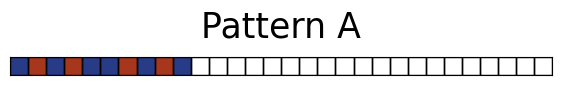

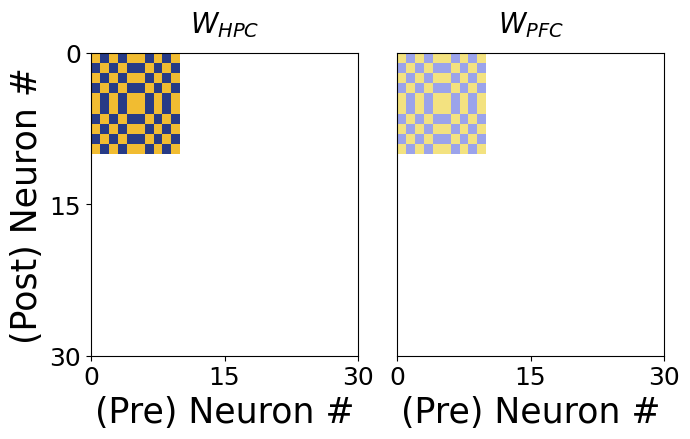

In [4]:
"""
Parameters
"""
n_HPC = 30
n_PFC = 30
n_total = n_HPC + n_PFC

learn_HPC = 0.45
decay_HPC = 0.55
learn_PFC = 0.06  # or 0.06
decay_PFC = 0
dt=0.01

"""
Initialize variables
"""
# Connectivity matrix
weights = np.zeros((n_total, n_total))
v1 = [i for i in range(n_HPC, n_total)] 
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=-1 # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# External input
P = np.array([-1, 1, -1,  1, -1,-1, 1, -1,  1, -1]) # pattern A
P_zeros = np.zeros(20)
P = np.concatenate((P, P_zeros)) # external input acting on one region
print('pattern to store:', P)
Pattern_A = np.copy(P) 
P=np.concatenate((P,P)) # external input acting on full HPC-PFC network


for days in range(3):
    
    print('day', days)
    
    # Awake Stage
    r, weights = run_awake(r, weights, P, t_dur=6500)
  
    # Sleeping stage
    r, weights = run_sleep(weights, t_NREM=300) 

weights_sleep_A = np.copy(weights)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


"""
Plots
"""
# Figure S1 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_A, 'Pattern A', cmap, ax=ax_input)

# Adjust layout and save the figure
plt.savefig('Pattern_A.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_d.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

## Pattern B - overlap 10% (awake stage)

New pattern B: [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0. -1.  0. -1.  1.  1.  0.  0.  0.  1.  1.  1.]


C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


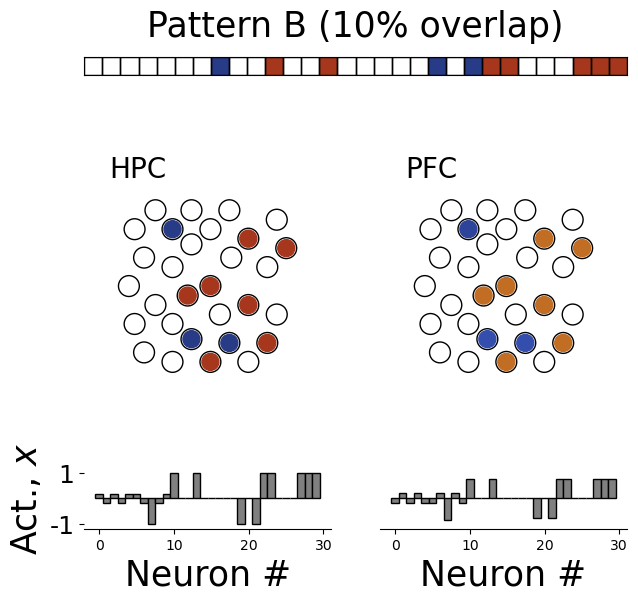

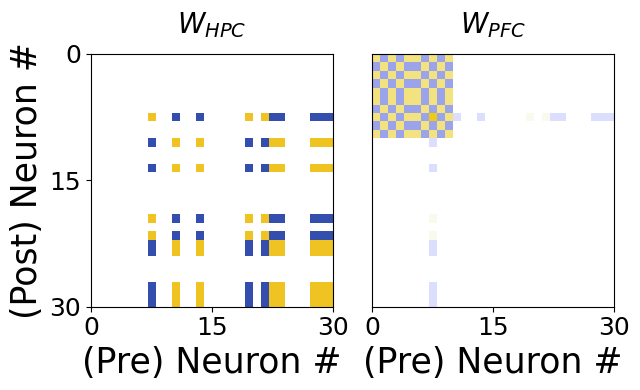

In [6]:
"""
Initialize variables
"""

# Connectivity matrix
weights = np.zeros((n_total, n_total)) # create connectiviy matrix of zeros
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set connectivity of PFC to weights storing pattern A
weights[v2,v1]=-1  # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# New pattern overlaping by 10% with A
I = get_overlap_array(Pattern_A, 0.1) # external input projecting to one region
print('New pattern B:', I)
Pattern_B10 = np.copy(I)
I=np.concatenate((I,I)) # external input acting on HPC-PFC network


"""
Run simulation
"""
# Awake Stage
r_final, weights_awake_B10 = run_awake(r, weights, I)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure S1 b1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B10, 'Pattern B (10% overlap)', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure2_a_days.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show


fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b_days.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



## Pattern B - overlap 90% (awake stage)

New pattern B: [-1.  1. -1.  1. -1.  0.  1. -1.  1. -1.  0.  0.  0. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


C:\Users\Florencia\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


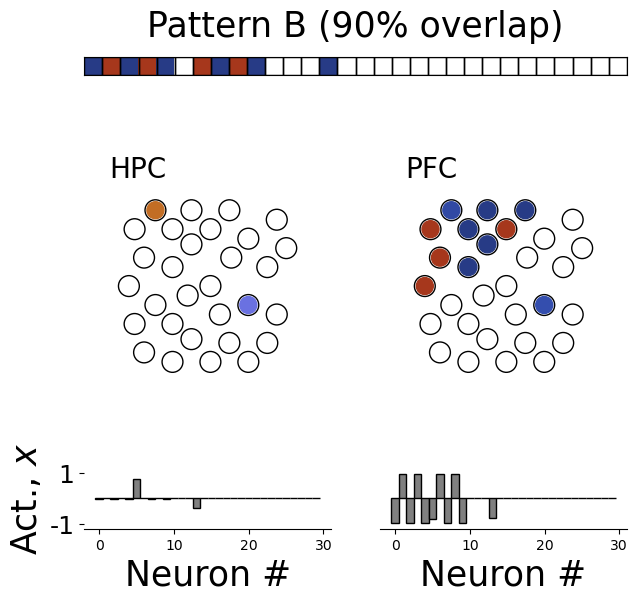

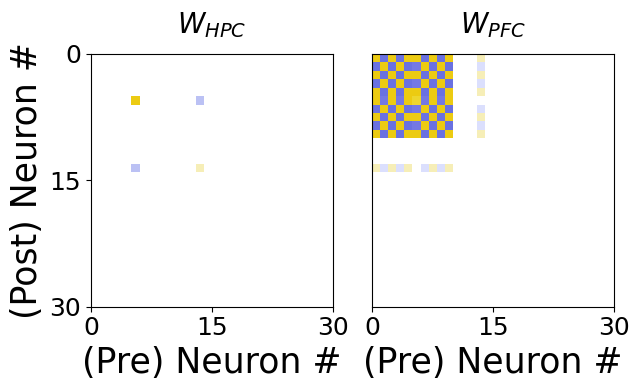

In [7]:
"""
Initialize variables
"""

# Connectivity matrix
weights = np.zeros((n_total, n_total)) # create connectiviy matrix of zeros
weights[n_HPC:,n_HPC:] = weights_sleep_A[n_HPC:,n_HPC:] # set connectivity of PFC to weights storing pattern A
weights[v2,v1]=-1  # inhibitory PFC-to-HPC connections
weights[v1,v2]=0.5 # excitatory HPC-to-PFC connections

# Firing rates
r =  np.zeros(n_total)

# New pattern overlaping by 10% with A
I = get_overlap_array(Pattern_A, 0.9) # external input projecting to one region
print('New pattern B:', I)
Pattern_B90 = np.copy(I)
I=np.concatenate((I,I)) # external input acting on HPC-PFC network


"""
Run simulation
"""
# Awake Stage
r_final, weights_awake_B90 = run_awake(r, weights, I)

r_final_HPC = r_final[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r_final[n_HPC:].reshape(1,n_HPC)

"""
Plots
"""
# Figure S1 b2)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input(Pattern_B90, 'Pattern B (90% overlap)', cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure3_a_days.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show


fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_b_days.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()